[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
day 253: buy 50 units at price 1283.874989, total balance 98716.125011
day 254: buy 50 units at price 1258.749962, total balance 97457.375050
day 255: buy 50 units at price 1205.624962, total balance 96251.750088
day 264: buy 50 units at price 1203.750038, total balance 95048.000050
day 268: buy 50 units at price 1167.749977, total balance 93880.250072
day 337: buy 50 units at price 1165.499973, total balance 92714.750099
day 338: buy 50 units at price 1159.000015, total balance 91555.750084
day 341: buy 50 units at price 1156.375027, total balance 90399.375057
day 342: buy 50 units at price 1129.249954, total balance 89270.125103
day 429, sell 50 units at price 1444.624996, investment 27.927833 %, total balance 90714.750099,
day 446, sell 50 units at price 1450.625038, investment 28.459163 %, total balance 92165.375137,
day 447, sell 50 units at pri

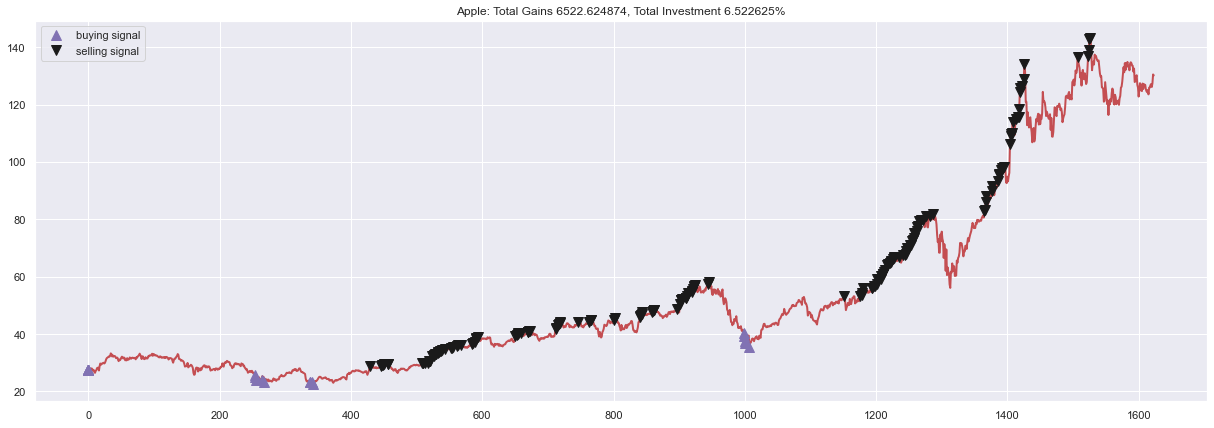

In [9]:

import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from pandas_datareader import data as pdr
import fix_yahoo_finance as yf

sns.set()

yf.pdr_override('AAPL')
df_full = pdr.get_data_yahoo("AAPL", start="2015-01-01").reset_index()
df_full.to_csv('AAPL.csv',index=False)

df = pd.read_csv("AAPL.csv")

name = 'Turtle Trading Agent'
count = int(np.ceil(len(df) * 0.1))
signals = pd.DataFrame(index=df.index)
signals['signal'] = 0.0
signals['trend'] = df['Close']

signals['Max'] = (signals.trend.shift(1).rolling(count).max())

signals['Min'] = (signals.trend.shift(1).rolling(count).min())

signals.loc[signals['Max'] < signals.trend, 'signal'] = -1 # If the actual price is higher than the max price of last X days then go long
signals.loc[signals['Min'] > signals.trend, 'signal'] = 1 # If the closing price is lower than the low price of last X days then short


def buy_stock(
    real_movement,
    signal,
    initial_money = 100000,
    max_buy = 50,
    max_sell = 50,
):

    starting_money = initial_money
    states_sell = []
    states_buy = []
    current_inventory = 0

    def buy(i, initial_money, current_inventory):
        shares = initial_money // real_movement[i]
        if shares < 1:
            print(
                'day %d: total balances %f, not enough money to buy a unit price %f'
                % (i, initial_money, real_movement[i])
            )
        else:
            if shares > max_buy:
                buy_units = max_buy
            else:
                buy_units = shares
            initial_money -= buy_units * real_movement[i]
            current_inventory += buy_units
            print(
                'day %d: buy %d units at price %f, total balance %f'
                % (i, buy_units, buy_units * real_movement[i], initial_money)
            )
            states_buy.append(0)
        return initial_money, current_inventory

#Buying the 
    for i in range(real_movement.shape[0] - int(0.025 * len(df))):
        state = signal[i]
        if state == 1:
            initial_money, current_inventory = buy(
                i, initial_money, current_inventory
            )
            states_buy.append(i)
        elif state == -1:
            if current_inventory == 0:
                    print('day %d: cannot sell anything, inventory 0' % (i))
            else:
                if current_inventory > max_sell:
                    sell_units = max_sell
                else:
                    sell_units = current_inventory
                current_inventory -= sell_units
                total_sell = sell_units * real_movement[i]
                initial_money += total_sell
                try:
                    invest = (
                        (real_movement[i] - real_movement[states_buy[-1]])
                        / real_movement[states_buy[-1]]
                    ) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell %d units at price %f, investment %f %%, total balance %f,'
                    % (i, sell_units, total_sell, invest, initial_money)
                )
            states_sell.append(i)
            
    invest = ((initial_money - starting_money) / starting_money) * 100
    total_gains = initial_money - starting_money
    return states_buy, states_sell, total_gains, invest
    
    
    
states_buy, states_sell, total_gains, invest = buy_stock(df.Close, signals['signal'])
    
    
close = df['Close']
fig = plt.figure(figsize = (21,7))
plt.plot(close, color='r', lw=2.)
plt.plot(close, '^', markersize=10, color='m', label = 'buying signal', markevery = states_buy)
plt.plot(close, 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell)
plt.title('Apple: Total Gains %f, Total Investment %f%%'%(total_gains, invest))
plt.legend()
plt.show()